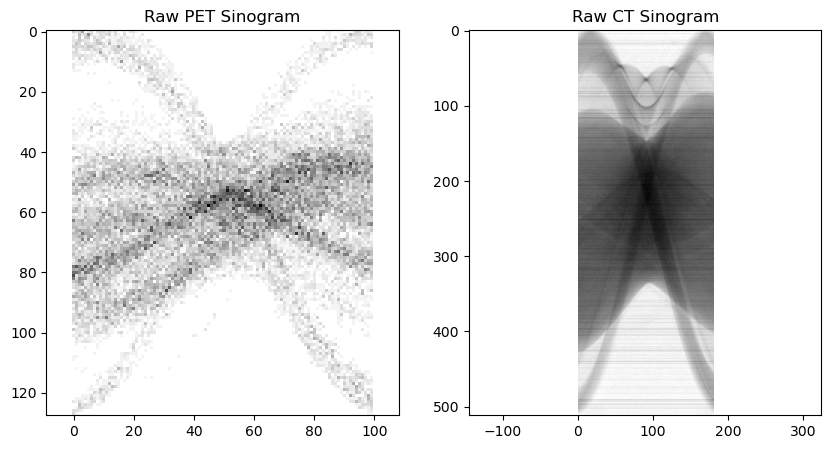

In [137]:
# Exercise 1.1.

import numpy as np
import matplotlib.pyplot as plt

# Load the sinogram data
ct_sino = np.load("ct_sinogram.npy")
pet_sino = np.load("pet_sinogram.npy")

# Display the raw sinograms
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(pet_sino, cmap="gray_r") 
plt.title("Raw PET Sinogram")
plt.axis("equal")

plt.subplot(122)
plt.imshow(ct_sino, cmap="gray")
plt.title("Raw CT Sinogram")
plt.axis("equal")
plt.savefig("PET_CT_sinogram")

plt.show()


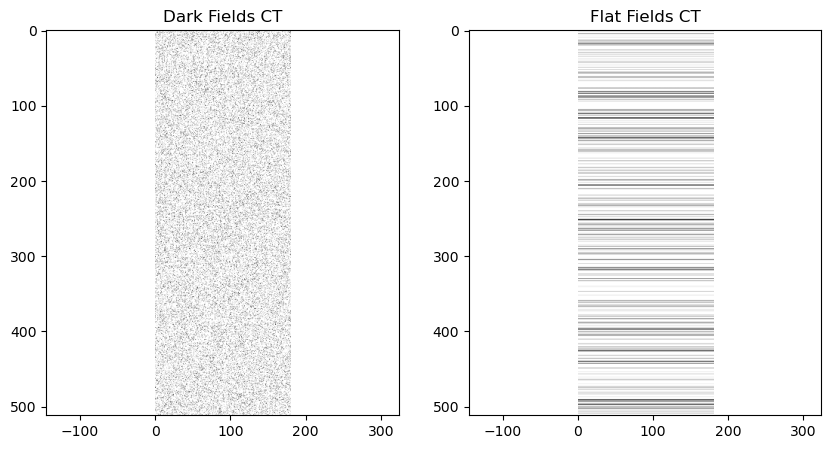

In [138]:
# Load the rest of the CT data 
ct_dark = np.load("ct_dark.npy")
ct_flat = np.load("ct_flat.npy")

# Display the dark and flat fields
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(ct_dark, cmap="gray_r")  
plt.title("Dark Fields CT")
plt.axis("equal")

plt.subplot(122)
plt.imshow(ct_flat, cmap="gray")
plt.title("Flat Fields CT")
plt.axis("equal")

plt.show()

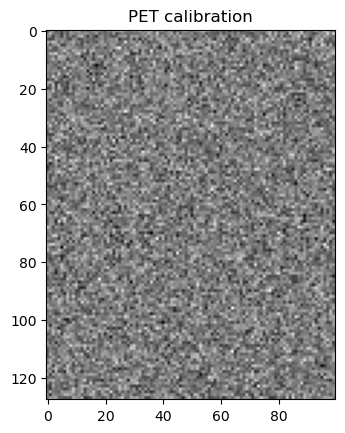

In [139]:
# Load and display the PET calibration
pet_calibration = np.load("pet_calibration.npy")
plt.imshow(pet_calibration, cmap="gray")
plt.title("PET calibration")
plt.show()

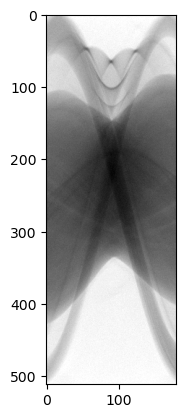

In [140]:
# Clean the CT image 
ct_corrected = (ct_sino - ct_dark) / (ct_flat - ct_dark)
plt.imshow(ct_corrected,cmap="gray")
plt.savefig("CT_Corrected")
plt.show()

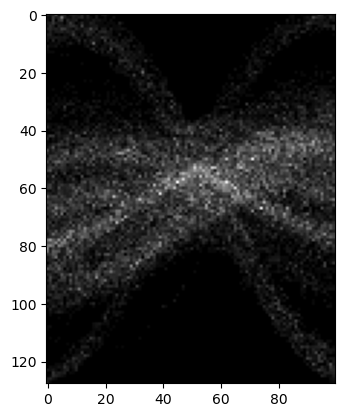

In [141]:
# Clean the PET image 
pet_corrected = pet_sino / pet_calibration
plt.imshow(pet_corrected,cmap="gray")
plt.savefig("PET_corrected")
plt.show()

OS-SART Execution Time: 0.4102 seconds


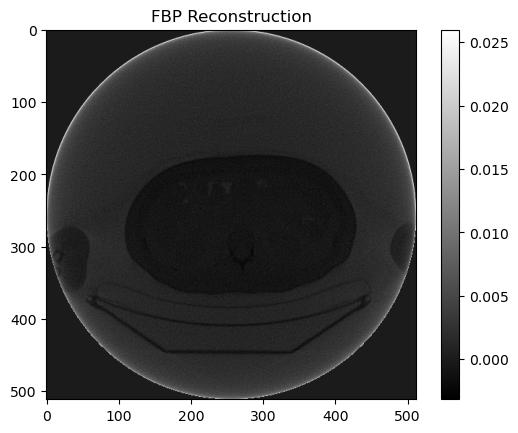

In [142]:
# Exercise 1.2.
# FBP Reconstruction

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon

def run_FBP():
    theta = np.linspace(0., 180., ct_corrected.shape[1], endpoint=False)  # Projection angles
    # Reconstruct using FBP
    ct_recon_fbp = iradon(ct_corrected, theta=theta, filter_name="ramp")


# Measure time
execution_time = timeit.timeit(run_FBP, number=1)
print(f"OS-SART Execution Time: {execution_time:.4f} seconds")
# Display the reconstructed image
plt.imshow(ct_recon_fbp, cmap="gray")
plt.title("FBP Reconstruction")
#plt.axis("off")
plt.colorbar()
plt.savefig("FBP_Recon")
plt.show()


OS-SART Execution Time: 50.9285 seconds


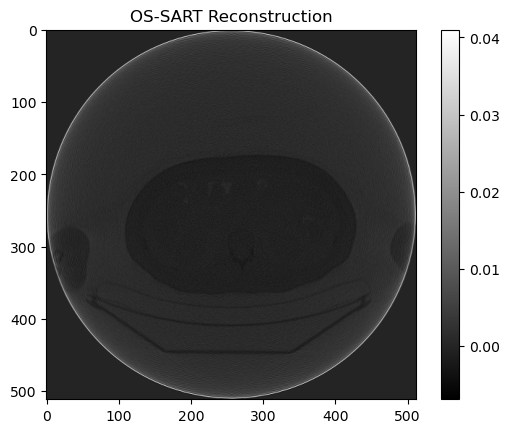

In [157]:
# OS-SART Reconstruction - Hyperparameter tuning 
from skimage.transform import iradon_sart

def run_ossart():
    # Initialize
    ct_recon_ossart = iradon_sart(ct_corrected, theta, relaxation=0.2)  # Initial step size γ=0.2
    # Run multiple iterations
    for _ in range(50):  # K iterations
        ct_recon_ossart = iradon_sart(ct_corrected, theta, image=ct_recon_ossart, relaxation=0.2)
    return ct_recon_ossart


# Call the function
ct_recon_ossart = run_ossart()
# Measure time
execution_time = timeit.timeit(run_ossart, number=1)
print(f"OS-SART Execution Time: {execution_time:.4f} seconds")

# Display OS-SART Reconstruction
plt.imshow(ct_recon_ossart, cmap="gray")
plt.title("OS-SART Reconstruction")
plt.colorbar()
plt.savefig("OS-SART_Recon")
plt.show()

OS-SART Execution Time: 10.8491 seconds


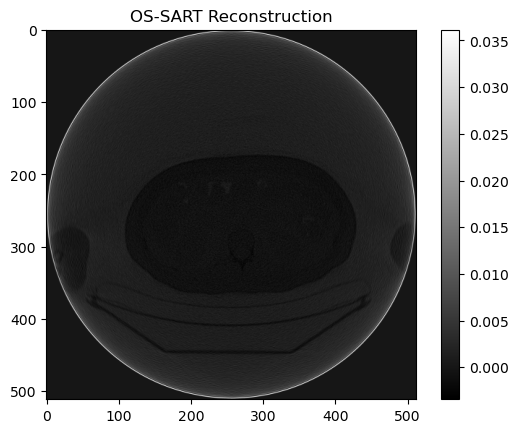

In [156]:
# OS-SART Reconstruction - optimal model
from skimage.transform import iradon_sart
import timeit

def run_ossart_optimal():
    # Initialize
    ct_recon_ossart_optimal = iradon_sart(ct_corrected, theta, relaxation=0.2)  # Initial step size γ=0.2
    # Run multiple iterations
    for _ in range(10):  # K iterations
        ct_recon_ossart_optimal = iradon_sart(ct_corrected, theta, image=ct_recon_ossart_optimal, relaxation=0.2)
    return ct_recon_ossart_optimal


# Call the function 
ct_recon_ossart_optimal = run_ossart_optimal()
# Measure time
execution_time = timeit.timeit(run_ossart_optimal, number=1)
print(f"OS-SART Execution Time: {execution_time:.4f} seconds")
    
# Display OS-SART Reconstruction
plt.imshow(ct_recon_ossart_optimal, cmap="gray")
plt.title("OS-SART Reconstruction")
plt.colorbar()
plt.savefig("OS-SART_Recon_Optimal")
plt.show()

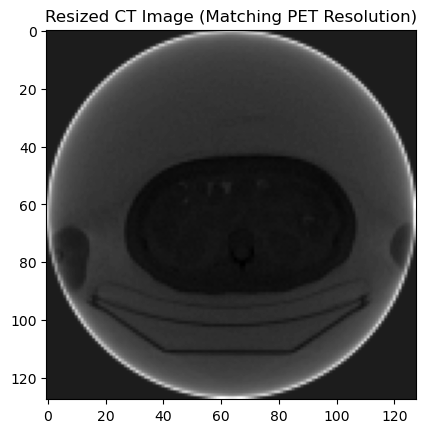

In [177]:
# Exercise 1.3.

# Compute scaling factor
scale_factor = 4.24 / 1.06
new_shape = (int(ct_recon_ossart_optimal.shape[0] / scale_factor), int(ct_recon_ossart_optimal.shape[1] / scale_factor))

# Resize CT image to match PET resolution
ct_resized = resize(ct_recon_ossart_optimal, new_shape, mode='reflect', anti_aliasing=True)

# Display resized image
plt.imshow(ct_resized, cmap="gray")
plt.title("Resized CT Image (Matching PET Resolution)")
plt.show()


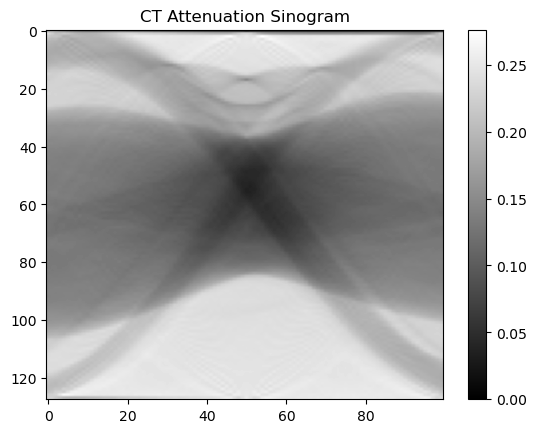

In [178]:
# Define projection angles (match PET sinogram)
theta_pet = np.linspace(0., 180., pet_sino.shape[1], endpoint=False)

# Generate attenuation sinogram using Radon Transform
ct_sino_attenuation = radon(ct_resized, theta=theta_pet, circle=True)

# Display attenuation sinogram
plt.imshow(ct_sino_attenuation, cmap="gray", aspect='auto')
plt.title("CT Attenuation Sinogram")
plt.colorbar()
plt.show()


In [179]:
# Resize attenuation sinogram to match PET sinogram size
ct_sino_attenuation_resized = resize(ct_sino_attenuation, pet_sino.shape, mode='reflect', anti_aliasing=True)

# Check shape after resizing
print(f"Resized CT Sinogram Shape: {ct_sino_attenuation_resized.shape}")
print(f"PET Sinogram Shape: {pet_sino.shape}")


Resized CT Sinogram Shape: (128, 100)
PET Sinogram Shape: (128, 100)


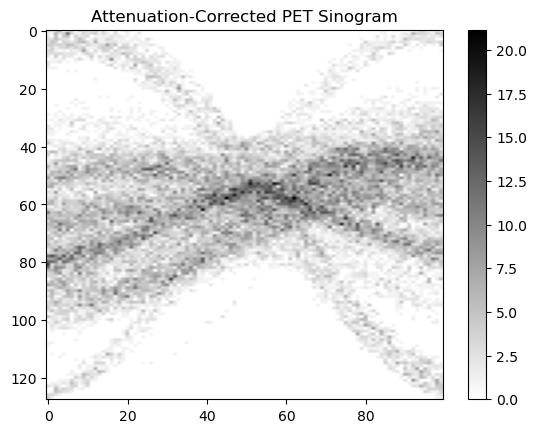

In [181]:
# Prevent overflow by clipping values
ct_sino_attenuation_resized = np.clip(ct_sino_attenuation_resized, -10, 10)

# Apply attenuation correction - Beer-Lambert
pet_sino_corrected = pet_sino * np.exp(ct_sino_attenuation_resized)

# Display corrected PET sinogram
plt.imshow(pet_sino_corrected, cmap="gray_r", aspect='auto')
plt.title("Attenuation-Corrected PET Sinogram")
plt.colorbar()
plt.savefig("PET_AC_sinogram")
plt.show()


OSEM Reconstruction Time: 0.03 seconds


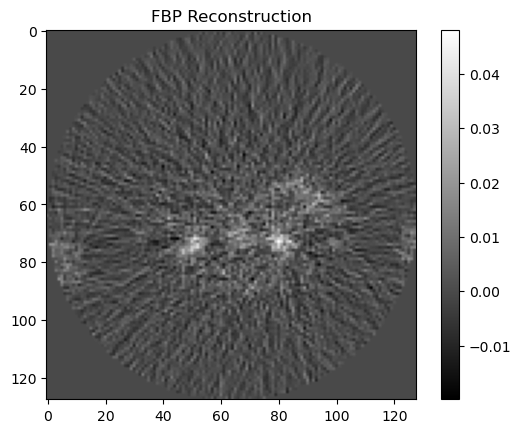

In [246]:
# Exercise 1.4.

# Start timing
start_time = time.time()

# Perform FBP reconstruction
theta = np.linspace(0., 180., pet_corrected.shape[1], endpoint=False)
fbp_reconstruction = iradon(pet_sino_corrected, theta=theta, filter_name="ramp")

# Stop timing
end_time = time.time()

# Print execution time
execution_time = (end_time - start_time)
print(f"OSEM Reconstruction Time: {execution_time:.2f} seconds")


# Display FBP result
plt.imshow(fbp_reconstruction, cmap="gray")
plt.title("FBP Reconstruction")
plt.colorbar()
plt.savefig("FBP_Reconstruction.png")
plt.show()


OSEM Reconstruction Time: 0.81 seconds


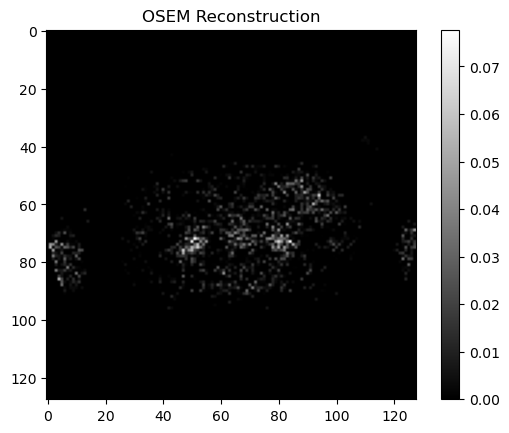

In [254]:
# OSEM reconstruction

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon

def forward_projection(image, theta):
    return radon(image, theta=theta, circle=True)

def back_projection(sinogram, theta):
    return iradon(sinogram, theta=theta, filter_name=None, circle=True)

def osem_reconstruction(sinogram, theta, num_subsets, num_iterations):
    img_size = sinogram.shape[0]  # Assume square image
    x = np.ones((img_size, img_size))  # Initial uniform image estimate

    subset_size = sinogram.shape[1] // num_subsets  # Subset partitions
    iteration_times = []

    for iteration in range(num_iterations):
        for i in range(num_subsets):
            subset_theta = theta[i * subset_size : (i + 1) * subset_size]
            A_x = forward_projection(x, subset_theta)  # Forward projection
            ratio = sinogram[:, i * subset_size : (i + 1) * subset_size] / (A_x + 1e-6)  # Avoid division by zero
            back_proj = back_projection(ratio, subset_theta)  # Back-projection
            x *= back_proj / (back_projection(np.ones_like(ratio), subset_theta) + 1e-6)  # Update step
    return x
# Define projection angles
theta = np.linspace(0., 180., pet_sino_corrected.shape[1], endpoint=False)

# Start timing
start_time = time.time()

# Perform OSEM reconstruction
osem_result = osem_reconstruction(pet_sino_corrected, theta, num_subsets=10, num_iterations=20)

# Stop timing
end_time = time.time()

# Print execution time
execution_time = (end_time - start_time)
print(f"OSEM Reconstruction Time: {execution_time:.2f} seconds")

# Display OSEM result
plt.imshow(osem_result, cmap="gray")
plt.title("OSEM Reconstruction")
plt.colorbar()
plt.savefig("OSEM_reconstruction.png")
plt.show()


MLEM Reconstruction Time: 1.95 seconds


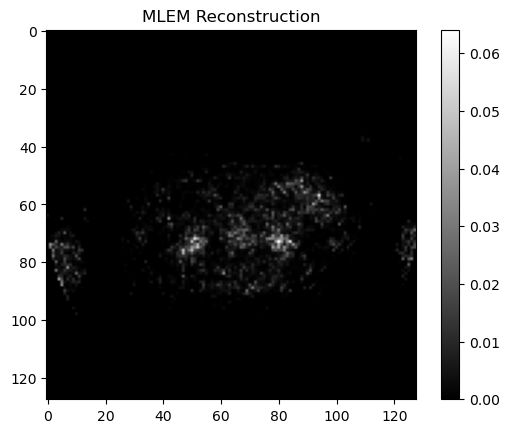

In [255]:
# MLEM reconstruction
import time

# Start timing
start_time = time.time()

# Run MLEM (OSEM with 1 subset)
mlem_reconstruction_result = osem_reconstruction(pet_sino_corrected, theta, num_subsets=1, num_iterations=50)

# Stop timing
end_time = time.time()
execution_time = (end_time - start_time)
print(f"MLEM Reconstruction Time: {execution_time:.2f} seconds")

# Display MLEM result
plt.imshow(mlem_reconstruction_result, cmap="gray")
plt.title("MLEM Reconstruction")
plt.colorbar()
plt.savefig("MLEM_Reconstruction.png")
plt.show()


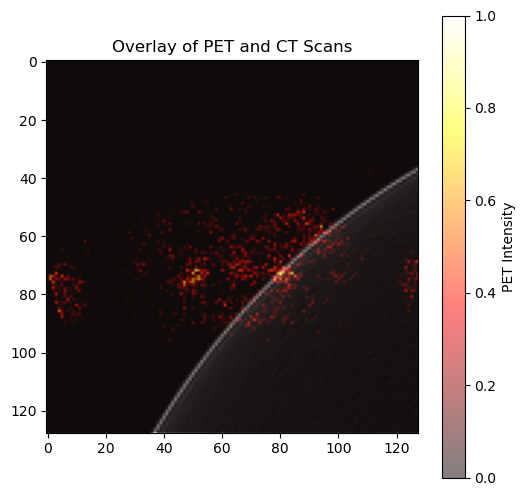

In [259]:
# Theory 1.5.
import numpy as np
import matplotlib.pyplot as plt


# Normalize images for better overlaying
ossart_ct_image = (ct_recon_ossart_optimal - np.min(ct_recon_ossart_optimal)) / (np.max(ct_recon_ossart_optimal) - np.min(ct_recon_ossart_optimal))
osem_pet_image = (osem_result - np.min(osem_result)) / (np.max(osem_result) - np.min(osem_result))

# Create the overlay plot
plt.figure(figsize=(6, 6))
plt.imshow(ossart_ct_image, cmap="gray", alpha=1)  # CT in grayscale
plt.imshow(osem_pet_image, cmap="hot", alpha=0.5)  # PET in heatmap with transparency

# Display the overlay
plt.title("Overlay of PET and CT Scans")
plt.colorbar(label="PET Intensity")
plt.savefig("PET_CT_Overlay")
plt.show()
